# Football Forecasting

Football is ubiquitous.The main objective of this project is to forecast football outcomes.... more flavor. 

We recreate the proposals of [Google](https://github.com/GoogleCloudPlatform/ipython-soccer-predictions) and [Goldman Sachs](http://www.goldmansachs.com/our-thinking/macroeconomic-insights/euro-cup-2016/) to tackle this task. We implemented both algortihms to predict the results of Comebol qualifiers and estimate the probability that Peru qualifies to the World Cup. Then, we propose a different approach in order to improve the accuaracy of the model. 


## Data
The database contains information at match level from seasons 2011/12, 2012/13 and 2013/14 for three leagues and the 2014 World Cup. The leagues included are:
* MLS (USA)
* Premier League (England)
* La Liga (Spain)
 
Attributes used for prediction consider the average of the last six games of each team (home and away).

In [1]:
import pandas as pd

# Import main dataset
parser2 = lambda date: pd.datetime.strptime(date, '%Y-%m-%d %H:%M:%f')
raw_data = pd.read_csv('./data/raw_data_ready.csv', index_col=0, header=0, 
                       parse_dates=['timestamp'], date_parser=parser2, 
                       encoding='utf-8')

# Partition the main dataset and the club data. We're only going to 
# train our model using club data.
club_data = raw_data.loc[raw_data['competitionid'] != 4]

    
# Generate a table with goals and points using club data.
points = club_data.replace({'points': {0: 'lose', 1: 'tie', 3: 'win'}})['points']
goals_points = pd.crosstab(club_data['goals'], points)

print('Goals and points:\n{0}'.format(goals_points))


Goals and points:
points  lose  tie  win
goals                 
0        727  267    0
1        477  394  320
2        131  205  500
3         21   40  314
4          2    6  148
5          0    2   65
6          0    0   12
7          0    0    6
8          0    0    1


## Google algorithm

Google implements a lasso logistic regression. Their most important weakness is the omission of tie predictions, which accounts to near 25% of the outcomes in the dataset.

### Training
The database is split into train and test with a 3 to 2 ratio. The model will be trained using the standardized train dataset. The target variable is a dummy that has a value equal to 1 if the team won and 0 if they lost. As mentioned before, ties are excluded from the analysis. The regularization parameter was selected through cross validation.

In [3]:
import code.wc_pred.world_cup as world_cup
import code.wc_pred.match_stats as match_stats

# Drop draws
train = club_data.loc[club_data['points'] != 1] 

# Train model
(model, test) = world_cup.train_model(train, match_stats.get_non_feature_columns())

# We print the Pseudo-Rsquared and the odds ratio increase generated by
# each attribute.
print('Rsquared: {0:.3f}'.format(model.prsquared))
print('Highest parameters from each category:')
world_cup.print_params(model, 5)

Rsquared: 0.153
Highest parameters from each category:
Positive features
is_home                  0.664457
pass_70                  0.394515
opp_op_expected_goals    0.187115
opp_op_pass_80           0.167198
opp_bad_passes           0.128878
dtype: float64

Dropped features
op_fouls          0.0
op_bad_passes     0.0
pass_ratio        0.0
corners           0.0
shots_op_ratio    0.0
dtype: float64

Negative features
opp_pass_70         -0.282905
op_expected_goals   -0.157622
op_pass_80          -0.143247
bad_passes          -0.114165
opp_avg_goals       -0.074598
dtype: float64


Without much surprise, the most important feature that determines the outcome of a match is the locality of the team. The second most important is the amount of passes done in the top 30% of the field.

### Forecasting

Predictions are made using the test set, which contains information that the model has not seen before. The logistic model returns the probability that the outcome variable will be 1. We have selected a threshold of 0.5 to decide if the outcome is 1 or 0.  

In [4]:
# Predict results for the test dataset.
results = world_cup.predict_model(model, test, 
                                  match_stats.get_non_feature_columns())

# The threshold selected for a win is 50 percent points.
threshold = 0.5

# Extract the predictions in a nice format.
predictions = world_cup.extract_predictions(
        results.copy(), results['predicted'], threshold*100)
    
# Print True Positives and False Positives using the 0.5 threshold (50 percent points).
correct = predictions[(predictions['predicted'] > threshold*100) & 
                      (predictions['points'] == 3)][:5]
incorrect = predictions[(predictions['predicted'] > threshold*100) &
                        (predictions['points'] < 3)][:5]
print('\nCorrect predictions:\n{0}'.format(correct))
print('\nIncorrect predictions:\n{0}'.format(incorrect))


Correct predictions:
             team_name op_team_name  predicted            expected  \
37           Barcelona   Villarreal  80.802775           Barcelona   
41       Real Sociedad   Real Betis  52.220781       Real Sociedad   
48  Atlético de Madrid       Getafe  74.321181  Atlético de Madrid   
59          Real Betis      Levante  55.049534          Real Betis   
60          Villarreal       Getafe  58.243117          Villarreal   

                winner  points  
37           Barcelona       3  
41       Real Sociedad       3  
48  Atlético de Madrid       3  
59          Real Betis       3  
60          Villarreal       3  

Incorrect predictions:
               team_name          op_team_name  predicted  \
8        Colorado Rapids             FC Dallas  51.103486   
12  Sporting Kansas City           D.C. United  54.258796   
14        Houston Dynamo  San Jose Earthquakes  51.835156   
21    New York Red Bulls            Toronto FC  52.312388   
24               Sevilla      

### Validation

Google validates their predictions using the Area Under the Curve (AUC) of a Reciever Operator Curve (ROC). This metric shows how better their predictions were compared to random chance. A value AUC of 1 implies that the model prerfectly predicts the outcome, while a value lower than 0.5 suggests that the model is not better than random chance. 

In this case, google selects the threshold based in the percentage of wins of the dataset.

Proportion of wins in club data: 0.375
Prediction metrics:
(3) Threshold: 0.577 | Lift: 1.460 Auc: 0.757
    Base: 0.375 Acc: 0.673 P(1|t): 0.730 P(0|f): 0.639
    Fp/Fn/Tp/Tn p/n/c: 102/227/276/401 503/503/1006


0.5773722051858738

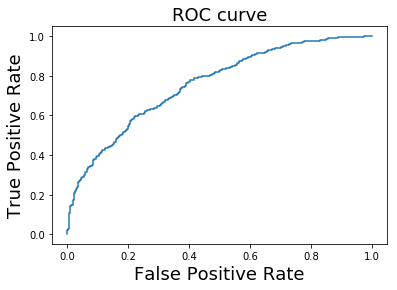

In [5]:
import matplotlib.pyplot as plt

# Compute a baseline, which is the percentage of overall outcomes 
# are actually wins (remember in soccer we can have draws too).
baseline = (sum([yval == 3 for yval in club_data['points']]) * 1.0 / len(club_data))
y = [yval == 3 for yval in test['points']]
print('Proportion of wins in club data: {0:.3f}'.format(baseline))

print('Prediction metrics:')
world_cup.validate(3, y, results['predicted'], baseline, 
                   compute_auc=True, quiet=False)
#plt.close()

### Improve the prediction

Google improved their prediction by incorporating a feature that reflects the toughness of the rivals that each team has faced. If team A has played dificult teams and won, we should expect that they beat team B, which has faced easier teams and won. They implement a power ranking to reflect this behaviour. 

The power calculations have been done within leagues. Since teams only face their league opponents, it would be difficult to assert if team A from league Z is better than tieam B from league W. We use game_summaries dataset to create the inputs for the power model because it contains all the matches played in the seasons selected.

The power algorithm follows these steps for each league:
1. Generate a matrix with rows representing games and columns representing teams.
2. For each element of the matrix, if the team 'i' participated match 'j', the element [j,i] of the matrix should be filled with a one. The value is zero otherwise. Here, teams the attributes and games are the observations. 
3. Add 0.25 to the element if the team is playing in home. Since home advantage is important in football, the model should reflect this fact. Adding 0.25 to the home team will reduce the 'power' estimated of this team.
4. Discount older seasons. Games from older seasons should have a higher value. Therefore, their contribution to the power estimation should be lower than recent seasons.
5. The target variable is points obtained by the first team minus points obtained by the second team. Therefore, the range of this variables is {-3, 3}. The function points_to_sgn is used to transform this variable into a binary one.
6. The model is estimated using a regularized logit. The regularization parameter starts at 0.5 and decreases each iteration until at least one coefficient is different than zero.
7. Extract the odds ratio of each attribute (team) and normalize it, so the range of the power variable is bounded between {0,1}. 

In [7]:
import code.wc_pred.power as power
import math

game_summaries = pd.read_csv('./data/game_summaries_mod.csv', 
                             index_col=0, header=0)
power_cols = [('points', world_cup.points_to_sgn, 'points'), ]
game_summaries = game_summaries.sort_values(['seasonid', 'matchid'],
                                            ascending = [False, True])
power_data = power.add_power(club_data, game_summaries, power_cols)
    
# Like before, exclude draws from the training set.
power_train = power_data.loc[power_data['points'] != 1] 


# Estimate the model using the club data we had plus our new power variable.
(power_model, power_test) = world_cup.train_model(power_train, 
                                                  match_stats.get_non_feature_columns())
# Report new pseudo r-quared.
print(' ')
print('Rsquared: {0:.3f}, Power Coef {1:.3f}.'.format(
      power_model.prsquared, 
      math.exp(power_model.params['power_points'])))

# Predict the outcomes of the test set. 
power_results = world_cup.predict_model(power_model, power_test, 
                                        match_stats.get_non_feature_columns())



Number of games: 496
New season 2014 -- Discount: 1.2


New season 2013 -- Discount: 0.72
QC check did not pass for 8 out of 20 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
Number of games: 760


New season 2013 -- Discount: 1.2


New season 2012 -- Discount: 0.72


QC check did not pass for 13 out of 24 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.
Number of games: 759


New season 2012 -- Discount: 1.2
New season 2011 -- Discount: 0.72


QC check did not pass for 9 out of 24 parameters
Try increasing solver accuracy or number of iterations, decreasing alpha, or switch solvers
Could not trim params automatically due to failed QC check.  Trimming using trim_mode == 'size' will still work.


 
Rsquared: 0.186, Power Coef 1.683.


(3) Threshold: 0.590 | Lift: 1.517 Auc: 0.779
    Base: 0.375 Acc: 0.694 P(1|t): 0.759 P(0|f): 0.656
    Fp/Fn/Tp/Tn p/n/c: 99/234/311/446 545/545/1090
(old) Threshold: 0.577 | Lift: 1.460 Auc: 0.757
    Base: 0.375 Acc: 0.673 P(1|t): 0.730 P(0|f): 0.639
    Fp/Fn/Tp/Tn p/n/c: 102/227/276/401 503/503/1006
 
Printing the five highest parameters from each category:
Positive features
is_home                  0.806905
power_points             0.682676
pass_ratio               0.138724
opp_op_corners           0.117026
opp_op_expected_goals    0.107545
dtype: float64

Dropped features
op_pass_70    0.0
avg_goals     0.0
op_shots      0.0
op_cards      0.0
op_fouls      0.0
dtype: float64

Negative features
opp_power_points    -0.405708
opp_pass_ratio      -0.121824
op_corners          -0.104766
op_expected_goals   -0.097102
opp_op_passes       -0.075073
dtype: float64


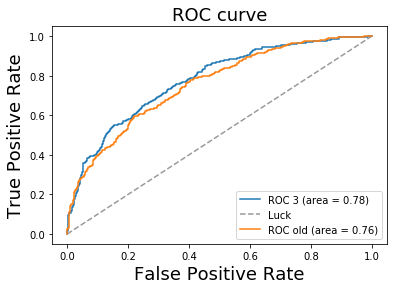

In [8]:
# Like before, extract metrics from the new model after predicting 
# outcomes of the test set.
power_y = [yval == 3 for yval in power_test['points']]
world_cup.validate(3, power_y, power_results['predicted'], baseline,
                   compute_auc=True, quiet=False)

# Print before and after ROC curve.
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Luck')
# Add the old model to the graph
world_cup.validate('old', y, results['predicted'], baseline, 
                   compute_auc=True, quiet=False)
plt.legend(loc="lower right")
#plt.close()

# Print estimated odds ratios.
print(' ')
print('Printing the five highest parameters from each category:')
world_cup.print_params(power_model, 5)


### Comebol predictions

We will use the model trained by google to predict the match outcomes of the Comebol qualifiers

In [9]:
# Import Comebol dataset
test_peru = pd.read_csv('./data/comebol_complete.csv', index_col=0, header=0)

results_peru = world_cup.predict_model(model, test_peru, 
                                       match_stats.get_non_feature_columns())

pred_peru = world_cup.extract_predictions(results_peru, 
                                          results_peru['predicted'], 50)
print('Peru predictions:\n{0}'.format(pred_peru))

Peru predictions:
    team_name op_team_name  predicted   expected     winner  points
0     Uruguay    Argentina  26.833858  Argentina  Argentina     0.0
1        Peru      Bolivia  62.831144       Peru       Peru     3.0
2     Ecuador       Brasil  21.722821     Brasil     Brasil     0.0
3    Paraguay        Chile  71.817039   Paraguay   Paraguay     3.0
4   Venezuela     Colombia  18.663949   Colombia   Colombia     0.0
5   Venezuela    Argentina  32.219905  Argentina       draw     1.0
6       Chile      Bolivia  72.076238      Chile      Chile     3.0
7    Colombia       Brasil  18.881380     Brasil     Brasil     0.0
8        Peru      Ecuador  79.163079       Peru       Peru     3.0
9     Uruguay     Paraguay  59.295010    Uruguay    Uruguay     3.0
10       Peru    Argentina  56.660185       Peru       draw     1.0
11     Brasil      Bolivia  92.371123     Brasil     Brasil     3.0
12    Ecuador        Chile  53.146423    Ecuador    Ecuador     3.0
13   Paraguay     Colombia  57

## Goldman Sachs algorithm

Golman Sachs also proposed a methodology to forecast football matches for the Euro 2016. They implemented a poisson regression to estimate the expected goals for each team in a match. Then, find the probability of home winning, away winning and draw.

The original variables used for estimating the scored goals are:
1. The difference in team performance as reflected in Elo ratings prior to the match. The Elo system was originally devised to rank chess players. It is a composite measure of national football team success that evolves depending on a team's results and the strength of its opponents.
2. The number of goals scored by team i in the last 10 competitive matches.
3. The number of goals conceded by team j in the last 2 competitive matches.
4. A home dummy.
5. A European Championship dummy to capture whether a team does systematically better at European Championships than in other competitive matches.

However, in our implementation we consider only the last four variables due to data limitations. We will train the Goldman Sachs algorithm using the main dataset used by google. Then, we will predict the outcomes of the Comebol qualifier matches.

In [11]:
import code.algorithms.models as models
import pickle

target_league = 'comebol'
last_year_dict = {'comebol': 2016}
# Opening main database
raw_df = pd.read_csv('{0}comebol_complete.csv'.format('./data/'),
                     header=0, index_col=0)

# Opening champions database
champions_df = pd.read_csv('{0}google/league_winners/{1}.csv'.format('./data/', target_league),
                           header=0, index_col=None)

# Preprocess data
raw_df = raw_df.rename(columns={'competitionid': 'league_id',
                                    'seasonid': 'season_id',
                                    'matchid': 'fixture_id',
                                    'teamid': 'localteam_id',
                                    'op_teamid': 'visitorteam_id',
                                    'timestamp': 'time.starting_at.date',
                                    'team_name': 'localTeam.data.name',
                                    'op_team_name': 'visitorTeam.data.name',
                                    'goals': 'scores.localteam_score',
                                    'op_goals': 'scores.visitorteam_score'})
opta_df = raw_df[['fixture_id', 'expected_goals', 'is_home']]
opta_df = models.convert_2match_to_1match(opta_df)

raw_df = raw_df.loc[raw_df['is_home'] == 1]
my_league = models.Fixture(raw_df, target_league, last_year=last_year_dict[target_league],
                           local_fixture=True)
my_league = my_league.clean_fixture(is_sportmonks=False)
my_league = my_league.generate_dataset(win_conceded=2, win_scored=2)
my_league = my_league.add_champion_dummy(champions_df)

# Open trained model
with open('{0}gs_model.pickle'.format('./output/goldman_sachs/'), 'rb') as handle:
    model = pickle.load(handle)

# Generate predictions
results_gs = my_league.get_matches_prediction(model)
results_gs.clean_results()
accuracy = results_gs.get_accuracy()
print('GS - Accuracy obtained: {0}'.format(accuracy))

results_gs = results_gs.fixture.rename(columns={'local_prob': 'gs_local_prob',
                                                'tie_prob': 'gs_tie_prob',
                                                'visitor_prob': 'gs_visitor_prob',
                                                'expected_winner': 'gs_expected_winner',
                                                'expected_score': 'gs_expected_score',
                                                'op_expected_score': 'gs_op_expected_score'})

results = pd.merge(results_gs, opta_df, how='inner', on=['fixture_id'])
squared_errors = models.get_squared_error(results)
print('Squared errors - GS: {0} | Google: {1}'.format(squared_errors[0],
                                                      squared_errors[1]))

2018-03-14 19:53:53,681 - code.algorithms.models - INFO - Main Fixture original size: (110, 13)


2018-03-14 19:53:53,683 - code.algorithms.models - INFO - Season 1 original size: (72, 13)


2018-03-14 19:53:53,736 - code.algorithms.models - INFO - Season 2 original size: (38, 13)


GS - Accuracy obtained: 0.5111111111111111
Squared errors - GS: 2.810022468204771 | Google: 3.1307691693244446
